# Generación de Modelos, busqueda de hiperparametros y comparación de los mismos


En este cuaderno (notebook), se generarán inicialmente todos los modelos en su forma básica. Posteriormente, tras obtener los resultados de estos modelos, se llevará a cabo una selección de aquellos que demuestren ser más precisos o cuyos resultados sean más pertinentes para el estudio del fraude. Seguidamente, se emprenderá una búsqueda exhaustiva de los mejores hiperparámetros para optimizar el rendimiento de los modelos seleccionados. Finalmente, se procederá a una comparación detallada entre los modelos optimizados, evaluando sus métricas de desempeño.

La primera etapa implicará la creación y evaluación de diversos modelos sin ajustes detallados, permitiendo así una exploración inicial de su capacidad predictiva. Una vez obtenidos los resultados, se realizará una cuidadosa selección de los modelos que demuestren ser más efectivos en la detección de fraudes o que proporcionen insights valiosos para el estudio.

En la segunda fase, nos sumergiremos en la búsqueda de los hiperparámetros óptimos para los modelos seleccionados. Este proceso implica ajustar los diversos parámetros que controlan el comportamiento de los modelos, con el objetivo de mejorar su capacidad predictiva y adaptarlos de manera específica a las características de los datos relacionados con fraudes.

En la última etapa, compararemos exhaustivamente los modelos optimizados, prestando especial atención a métricas clave como precisión, recall, F1-score y el área bajo la curva ROC (ROC-AUC). Este análisis detallado nos permitirá tomar decisiones informadas sobre cuál de los modelos es el más adecuado para nuestro propósito, proporcionando así una base sólida para la conclusión y análisis final del estudio de detección de fraudes.

### Librerias ###

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold, chi2, SelectFromModel
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, auc, accuracy_score, classification_report, confusion_matrix,
                             f1_score, fbeta_score, make_scorer, precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve, silhouette_score)
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle
import warnings
warnings.filterwarnings("ignore")

c:\Users\Victor\Anaconda3\envs\ST\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Funciones

In [2]:
def evaluate_classifiers(X_train, y_train, X_val, y_val):
     
    """
    Evalúa varios clasificadores en un conjunto de datos de entrenamiento y validación.

    Parámetros:
    - X_train: Conjunto de datos de características de entrenamiento.
    - y_train: Conjunto de etiquetas de entrenamiento.
    - X_val: Conjunto de datos de características de validación.
    - y_val: Conjunto de etiquetas de validación.

    Retorna:
    - results: Un diccionario que contiene información sobre cada clasificador evaluado,
               incluyendo el modelo, puntuación ROC AUC, precisión y el informe de clasificación.
    """
    # Definir una lista de clasificadores.
    
    classifiers = [
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        AdaBoostClassifier(),
        LGBMClassifier(),
        XGBClassifier(),
    ]

    # Inicializar un diccionario vacío para almacenar los resultados de cada clasificador.
    results = {}

    # Iterar sobre cada clasificador en la lista.
    for classifier in classifiers:
        # Crear un pipeline con el clasificador.
        pipe = Pipeline(steps=[('classifier', classifier)])
        
        # Ajustar el pipeline a los datos de entrenamiento.
        pipe.fit(X_train, y_train)
        
        # Usar el pipeline ajustado para hacer predicciones en los datos de validación.
        pred = pipe.predict(X_val)

        # Si el clasificador tiene un método para predecir probabilidades, usarlo para calcular la puntuación ROC AUC.
        if hasattr(classifier, 'predict_proba'):
            score = pipe.predict_proba(X_val)[:, 1]
            roc_auc = roc_auc_score(y_val, score)
        else:
            roc_auc = "N/A"
        
        # Calcular la precisión del clasificador.
        accuracy = accuracy_score(y_val, pred)
        
        # Generar un informe de clasificación.
        class_report = classification_report(y_val, pred)

        # Imprimir el clasificador, la puntuación ROC AUC, la precisión y el informe de clasificación.
        print('==========================================================')
        print(str(classifier))
        print('==========================================================')
        print("roc_auc: {}".format(roc_auc))
        print("accuracy: {}".format(accuracy))
        print("classification report:\n {}".format(class_report))

        # Almacenar los resultados en el diccionario.
        results[str(classifier)] = {
            'model' : pipe, 
            'roc_auc': roc_auc,
            'accuracy': accuracy,
            'class_report': class_report
        }
    
    

In [3]:
def evaluate_model(model_name, y_test, pred, pred_proba=None):
    """
    Imprime métricas de evaluación y un informe de clasificación para un modelo dado.

    Parámetros:
    - model_name: Nombre del modelo.
    - y_test: Etiquetas reales del conjunto de prueba.
    - pred: Predicciones del modelo.
    - pred_proba: Probabilidades de las predicciones (opcional).

    No retorna nada; imprime los resultados directamente.
    """
    # Imprimir el nombre del modelo.
    print('==========================================================')
    print(f'Modelo: {model_name}')
    print('==========================================================')

    # Si se proporcionan las probabilidades de las predicciones, calcular e imprimir la puntuación ROC-AUC del modelo.
    if pred_proba is not None:
        roc_auc = roc_auc_score(y_test, pred_proba[:, 1])
        print(f'Puntuación ROC-AUC del modelo: {roc_auc:.4f}')

    # Calcular e imprimir la precisión del modelo.
    accuracy = accuracy_score(y_test, pred)
    print(f'Precisión del modelo: {accuracy:.4f}\n')

    # Generar e imprimir un informe de clasificación, que incluye precisión, recall, f1-score, y soporte.
    classification_rep = classification_report(y_test, pred)
    print('Informe de clasificación:\n', classification_rep)

In [4]:
def plot_evaluation_metrics(y_test, pred, pred_proba):
    """
    Visualiza varias métricas de evaluación de un modelo de clasificación.

    Parámetros:
    - y_test: Etiquetas reales del conjunto de prueba.
    - pred: Predicciones del modelo.
    - pred_proba: Probabilidades de las predicciones.

    No retorna nada; muestra la visualización directamente.
    """
    # Crear una figura con subfiguras
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

    # 1. Matriz de Confusión
    conf_matrix = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1])
    disp.plot(cmap='Blues', values_format='d', ax=axes[0, 0])
    axes[0, 0].set_title(f'Matriz de Confusión\nAccuracy: {accuracy:.2f}')

    # 2. Matriz de Confusión Normalizada
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    disp_normalized = ConfusionMatrixDisplay(conf_matrix_normalized, display_labels=[0, 1])
    disp_normalized.plot(cmap='Blues', values_format='.2f', ax=axes[0, 1])
    axes[0, 1].set_title('Matriz de Confusión Normalizada')

    # 3. Curva ROC
    yhat = pred_proba[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, yhat)
    axes[1, 0].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    axes[1, 0].plot(fpr, tpr, marker='.', label='LGBM')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].legend()
    axes[1, 0].set_title('Curva ROC')

    # 4. Mejor umbral según G-Mean
    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)
    axes[1, 1].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    axes[1, 1].plot(fpr, tpr, marker='.', label=f'LGBM')
    axes[1, 1].scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].legend()
    axes[1, 1].set_title(f'Mejor Umbral (G-Mean)\nThreshold: {thresholds[ix]:.3f}, G-Mean: {gmeans[ix]:.3f}')

    # 5. Curva de Precisión y Recall
    precision, recall, thresholds = precision_recall_curve(y_test, yhat)
    axes[2, 0].plot([0, 1], [len(y_test[y_test == 1]) / len(y_test), len(y_test[y_test == 1]) / len(y_test)],
                   linestyle='--', label='No Skill')
    axes[2, 0].plot(recall, precision, marker='.', label=f'LGBM')
    axes[2, 0].set_xlabel('Recall')
    axes[2, 0].set_ylabel('Precision')
    axes[2, 0].legend()
    axes[2, 0].set_title('Curva de Precisión y Recall')

    # 6. Mejor umbral según F-Score
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    axes[2, 1].plot([0, 1], [len(y_test[y_test == 1]) / len(y_test), len(y_test[y_test == 1]) / len(y_test)],
                   linestyle='--', label='No Skill')
    axes[2, 1].plot(recall, precision, marker='.', label=f'LGBM')
    axes[2, 1].scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
    axes[2, 1].set_xlabel('Recall')
    axes[2, 1].set_ylabel('Precision')
    axes[2, 1].legend()
    axes[2, 1].set_title(f'Mejor Umbral (F-Score)\nThreshold: {thresholds[ix]:.3f}, F-Score: {fscore[ix]:.3f}')

    # Ajustes de diseño y visualización final
    plt.tight_layout()
    plt.show()


### Division de los datos en train, test y validacion

In [5]:
X = pd.read_csv("../data/X.csv")
y = pd.read_csv("../data/y.csv")

In [6]:
X.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.9,0.166828,60.719967,88.0,50,0.020925,36.582496,769,10650.765523,3134.319630,...,0,0,0,1,0,0,0,0,1,0
1,0.9,0.296286,60.719967,144.0,50,0.005418,36.582496,366,534.047319,2670.918292,...,0,0,0,1,0,0,0,0,1,0
2,0.9,0.044985,60.719967,132.0,40,3.108549,36.582496,870,4048.534263,2893.621498,...,0,0,0,1,0,0,0,1,0,0
3,0.9,0.159511,60.719967,22.0,50,0.019079,36.582496,810,3457.064063,4054.908412,...,0,0,0,1,0,1,0,0,0,0
4,0.9,0.596414,60.719967,218.0,50,0.004441,36.582496,890,5020.341679,2728.237159,...,0,0,0,1,0,0,1,0,0,0


In [7]:
y.head()

,fraud_bool
0,1
1,1
2,1
3,1
4,1


In [8]:
# Separo en train_0 y test
X_train_0, X_test, y_train_0, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


In [9]:
# Separo en train_1 y val
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train_0, y_train_0, test_size=0.2, random_state=12)

print('Proporción de clases en y_train:', Counter(y_train_1))


Proporción de clases en y_train: Counter({'fraud_bool': 1})


### Undersampling de la muestra

In [10]:
# Crear el objeto RandomUnderSampler con la proporción deseada, en este caso la de 0.1, es decir, 10% de la clase minoritaria
under_sampler = RandomUnderSampler(sampling_strategy=0.1, random_state=12)

# Aplicar el método de remuestreo
X_train_1, y_train_1 = under_sampler.fit_resample(X_train_1, y_train_1)

# Verificar la proporción después del undersampling
print('Undersampled dataset shape %s' % Counter(y_train_1))


Undersampled dataset shape Counter({'fraud_bool': 1})


Aplicamos un undersampling, en este caso la de 0.1, es decir, 10% de la clase minoritaria. 

Esto quiere decir que haya una proporción de 90% no fraude y un 10% de fraude en el Train_1 que utilizaremos para los modelos en bruto y que compararemos con la validación.

In [11]:
# Aplicar undersampling a tus datos
X_train_2, y_train_2 = under_sampler.fit_resample(X_train_0, y_train_0)

# Verificar la proporción después del undersampling
print('Undersampled dataset shape %s' % Counter(y_train_2))


Undersampled dataset shape Counter({'fraud_bool': 1})


Aplicamos un undersampling, en este caso la de 0.1, es decir, 10% de la clase minoritaria. 

Esto quiere decir que haya una proporción de 90% no fraude y un 10% de fraude en el Train_2 que utilizaremos para los modelos con hiperparametros y que compararemos con el test.

## 1º Etapa:
### Creación y evaluación de los modelos sin ajustes 


En la primera etapa de nuestro análisis, exploraremos y evaluaremos un conjunto diverso de modelos de clasificación. Estos modelos incluirán:

- DecisionTreeClassifier()
- RandomForestClassifier()
- GradientBoostingClassifier()
- AdaBoostClassifier()
- LGBMClassifier()
- XGBClassifier()

Cada uno de estos modelos se implementará en su forma básica, sin ajustes detallados de hiperparámetros. Este enfoque nos permitirá obtener una visión inicial de la capacidad predictiva de cada modelo en relación con el problema de detección de fraudes.

Durante esta fase, se llevará a cabo el siguiente proceso para cada modelo:

Creación del Modelo: Se instanciará cada clasificador correspondiente.
Entrenamiento del Modelo: Se utilizarán los datos de entrenamiento para ajustar cada modelo a los patrones presentes en los datos.
Predicciones en el Conjunto de Validación: Se utilizará el modelo entrenado para realizar predicciones en un conjunto de datos de validación separado.
Evaluación de Desempeño: Se calcularán y analizarán diversas métricas de evaluación, como la precisión, recall, F1-score y el área bajo la curva ROC (ROC-AUC). Estas métricas proporcionarán información valiosa sobre la capacidad de cada modelo para detectar fraudes y su rendimiento general.
Una vez completada esta fase inicial, estaremos en una posición adecuada para seleccionar los modelos que muestren un desempeño prometedor. Estos modelos seleccionados serán la base sobre la cual realizaremos ajustes más detallados en la siguiente etapa del análisis. Este enfoque iterativo nos permitirá construir gradualmente modelos más refinados y adaptados a la naturaleza específica del problema de detección de fraudes.

In [12]:
evaluate_classifiers(X_train_1, y_train_1, X_val, y_val)

DecisionTreeClassifier()
roc_auc: 0.6411765645993103
accuracy: 0.9180375
classification report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.96    158198
           1       0.05      0.36      0.09      1802

    accuracy                           0.92    160000
   macro avg       0.52      0.64      0.52    160000
weighted avg       0.98      0.92      0.95    160000

RandomForestClassifier()
roc_auc: 0.8761011731193039
accuracy: 0.9835125
classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    158198
           1       0.24      0.21      0.22      1802

    accuracy                           0.98    160000
   macro avg       0.61      0.60      0.61    160000
weighted avg       0.98      0.98      0.98    160000

GradientBoostingClassifier()
roc_auc: 0.8967798421565276
accuracy: 0.9792
classification report:
               precision    recall  f1-score   support


Tras completar la primera etapa de nuestro análisis, hemos evaluado diversos modelos de clasificación, entre los cuales los más destacados por su desempeño prometedor han sido el GradientBoostingClassifier, AdaBoostClassifier, LGBMClassifier, y XGBClassifier. Estos modelos han demostrado una capacidad considerable para predecir y detectar fraudes en nuestro conjunto de datos de validación.

Basándonos en las métricas de evaluación, que incluyen precisión, recall, F1-score y el área bajo la curva ROC (ROC-AUC), hemos identificado que estos clasificadores muestran resultados alentadores y prometedores para el propósito de nuestro estudio de detección de fraudes.

Ahora, avanzaremos a la segunda etapa del análisis, donde nos enfocaremos en la búsqueda de los mejores hiperparámetros para optimizar aún más el rendimiento de estos modelos seleccionados. Este paso crucial nos permitirá ajustar cada modelo de manera más específica a las características de nuestro conjunto de datos y mejorar su capacidad predictiva. Continuaremos con un enfoque metódico y riguroso para garantizar la obtención de resultados óptimos en la detección de fraudes.

## 2º Etapa:
### Optimización de Hiperparámetros y Selección del Modelo
Después de seleccionar los modelos en la primera etapa, que incluyeron GradientBoostingClassifier, AdaBoostClassifier, LGBMClassifier, y XGBClassifier, nos sumergiremos en la búsqueda de los hiperparámetros óptimos para cada uno de ellos. Este paso es crucial para afinar el rendimiento de los modelos y obtener resultados más precisos en la detección de fraudes.


#### Optimización de Hiperparámetros

Iniciaremos creando pipelines para cada modelo y emplearemos técnicas de búsqueda aleatoria, en este caso, RandomizedSearchCV, para explorar diferentes combinaciones de hiperparámetros. Este proceso permitirá encontrar la configuración óptima que maximiza el rendimiento de cada modelo. Para cada modelo hay un notebook en el que se realiza todos estos pasos, en el caso del XGBClassifier ponemos su ejemplo a continuación:


In [13]:
# Creamos el pipeline
xgb_model = Pipeline([
    ('classifier', GradientBoostingClassifier(random_state=12))
])

In [14]:
# Introducimos los parámetros a probar
xgb_params = {
    'classifier__max_depth': [2, 4, 6, 8, 10],
    'classifier__learning_rate': [0.05, 0.1, 0.15, 0.20],
    'classifier__n_estimators': [20, 40, 60, 80, 100],
    'classifier__min_samples_split': [2, 3, 4],
    'classifier__min_samples_leaf': [1, 2, 3, 4],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

# Definimos la búsqueda aleatoria
CV= RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params, cv=3, n_jobs=-1, verbose=2)

                                      

In [15]:
# Ajustamos el modelo
XGB_model = CV.fit(X_train_2, y_train_2)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [16]:
#Guardamos el modelo como pickle, para de esta manera poder comparar los resultados con otros modelos

#with open('../models/xgb_model_02.pkl', 'wb') as file:
#    pickle.dump(XGB_model, file)

Repetiremos este proceso para cada modelo seleccionado en diferentes nootebooks.



#### Carga de los modelos entrenados con hiperparametros con pickel

In [17]:
# Cargamos el modelo XGB
with open('../models/xgb_model_02.pkl', 'rb') as file:
    XGB_model = pickle.load(file)

# Mejores parámetros que se utilizarán para la explicabilidad del modelo
modelo_XGB_best_estim = XGB_model.best_estimator_

# Guardamos el modelo como pickle para ejecutarlo en otro notebook
pickle.dump(modelo_XGB_best_estim, open('../models/modelo_XGB_best_estim.pkl', 'wb'))

# Prediccion con el modelo
pred_xgb = XGB_model.best_estimator_.predict(X_test)

# Prediccion de probabilidades con el modelo
pred_proba_xgb = XGB_model.best_estimator_.predict_proba(X_test)

In [18]:
# Cargamos el modelo LGBM
with open('../models/LGBM_model_02.pkl', 'rb') as file:
    LGBM_model = pickle.load(file)

# Prediccion con el modelo
pred_lgbm = LGBM_model.best_estimator_.predict(X_test)

# Prediccion de probabilidades con el modelo
pred_proba_lgbm = LGBM_model.best_estimator_.predict_proba(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [19]:
# Cargamos el modelo ADA
with open('../models/ADA_model_01.pkl', 'rb') as file:
    ADA_model = pickle.load(file)

# Prediccion con el modelo
pred_ada = ADA_model.best_estimator_.predict(X_test)

# Prediccion de probabilidades con el modelo
pred_proba_ada = ADA_model.best_estimator_.predict_proba(X_test)

In [20]:
# Cargamos el modelo GB
with open('../models/GB_model_01.pkl', 'rb') as file:
    GB_model = pickle.load(file)

# Prediccion con el modelo
pred_gb = GB_model.best_estimator_.predict(X_test)

# Prediccion de probabilidades con el modelo
pred_proba_gb = GB_model.best_estimator_.predict_proba(X_test)

### Evaluación y Comparación de Modelos
Después de obtener los modelos optimizados, realizaremos predicciones en el conjunto de prueba y evaluaremos su desempeño utilizando diversas métricas. Posteriormente, compararemos los resultados de cada modelo, prestando especial atención a métricas clave como F1-score, recall y precisión.

In [21]:
# Evaluamos el modelo LGMB

model_name = "LGBMClassifier"

evaluate_model(model_name,y_test, pred_lgbm,pred_proba_lgbm)


Modelo: LGBMClassifier
Puntuación ROC-AUC del modelo: 0.8967
Precisión del modelo: 0.9761

Informe de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    197865
           1       0.18      0.35      0.24      2135

    accuracy                           0.98    200000
   macro avg       0.59      0.67      0.61    200000
weighted avg       0.98      0.98      0.98    200000



In [22]:
# Evaluamos el modelo ADA

model_name = "ADABoostClassifier"

evaluate_model(model_name,y_test, pred_ada,pred_proba_ada)


Modelo: ADABoostClassifier
Puntuación ROC-AUC del modelo: 0.8888
Precisión del modelo: 0.9804

Informe de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    197865
           1       0.20      0.27      0.23      2135

    accuracy                           0.98    200000
   macro avg       0.59      0.63      0.61    200000
weighted avg       0.98      0.98      0.98    200000



In [23]:
# Evaluamos el modelo XGB

model_name = "XGBoostClassifier"

evaluate_model(model_name,y_test, pred_xgb,pred_proba_xgb)


Modelo: XGBoostClassifier
Puntuación ROC-AUC del modelo: 0.9124
Precisión del modelo: 0.9807

Informe de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    197865
           1       0.23      0.33      0.27      2135

    accuracy                           0.98    200000
   macro avg       0.61      0.66      0.63    200000
weighted avg       0.98      0.98      0.98    200000



In [24]:
# Evaluamos el modelo GB

model_name = "GBClassifier"

evaluate_model(model_name,y_test, pred_gb,pred_proba_gb)

Modelo: GBClassifier
Puntuación ROC-AUC del modelo: 0.8953
Precisión del modelo: 0.9778

Informe de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    197865
           1       0.19      0.32      0.24      2135

    accuracy                           0.98    200000
   macro avg       0.59      0.65      0.61    200000
weighted avg       0.98      0.98      0.98    200000



Después de una exhaustiva comparación uno a uno de todos los modelos evaluados, destacamos los siguientes resultados clave:

- El mejor F1-score se logra con el modelo XGBoost, alcanzando un total de 0,27.

- A pesar de ello, el modelo LGBM exhibe el recall más alto, con un total de 0,35, superando al modelo XGBoost por una pequeña diferencia de 0,02.

Aunque reconocemos esta diferencia en el recall, consideramos que es insignificante en el contexto de la capacidad general de ambos modelos para predecir fraudes en el conjunto de prueba. Ambos modelos han demostrado una habilidad casi igual en esta tarea.

Dada la ligera ventaja en el F1-score y el cómputo general de sus resultados, hemos tomado la decisión de seleccionar el modelo **XGBoost** como la opción preferida. Este modelo será la base para la visualización de métricas y la explicabilidad, proporcionando una sólida base para futuros análisis y toma de decisiones.

## 3º Etapa:
### Visualización Detallada de Métricas de Evaluación para el modelo seleccionado (XGBoost)
Esta visualización nos permitirá evaluar el rendimiento del modelo XGBoost desde diversas perspectivas, facilitando la interpretación de su capacidad para detectar fraudes de manera efectiva.

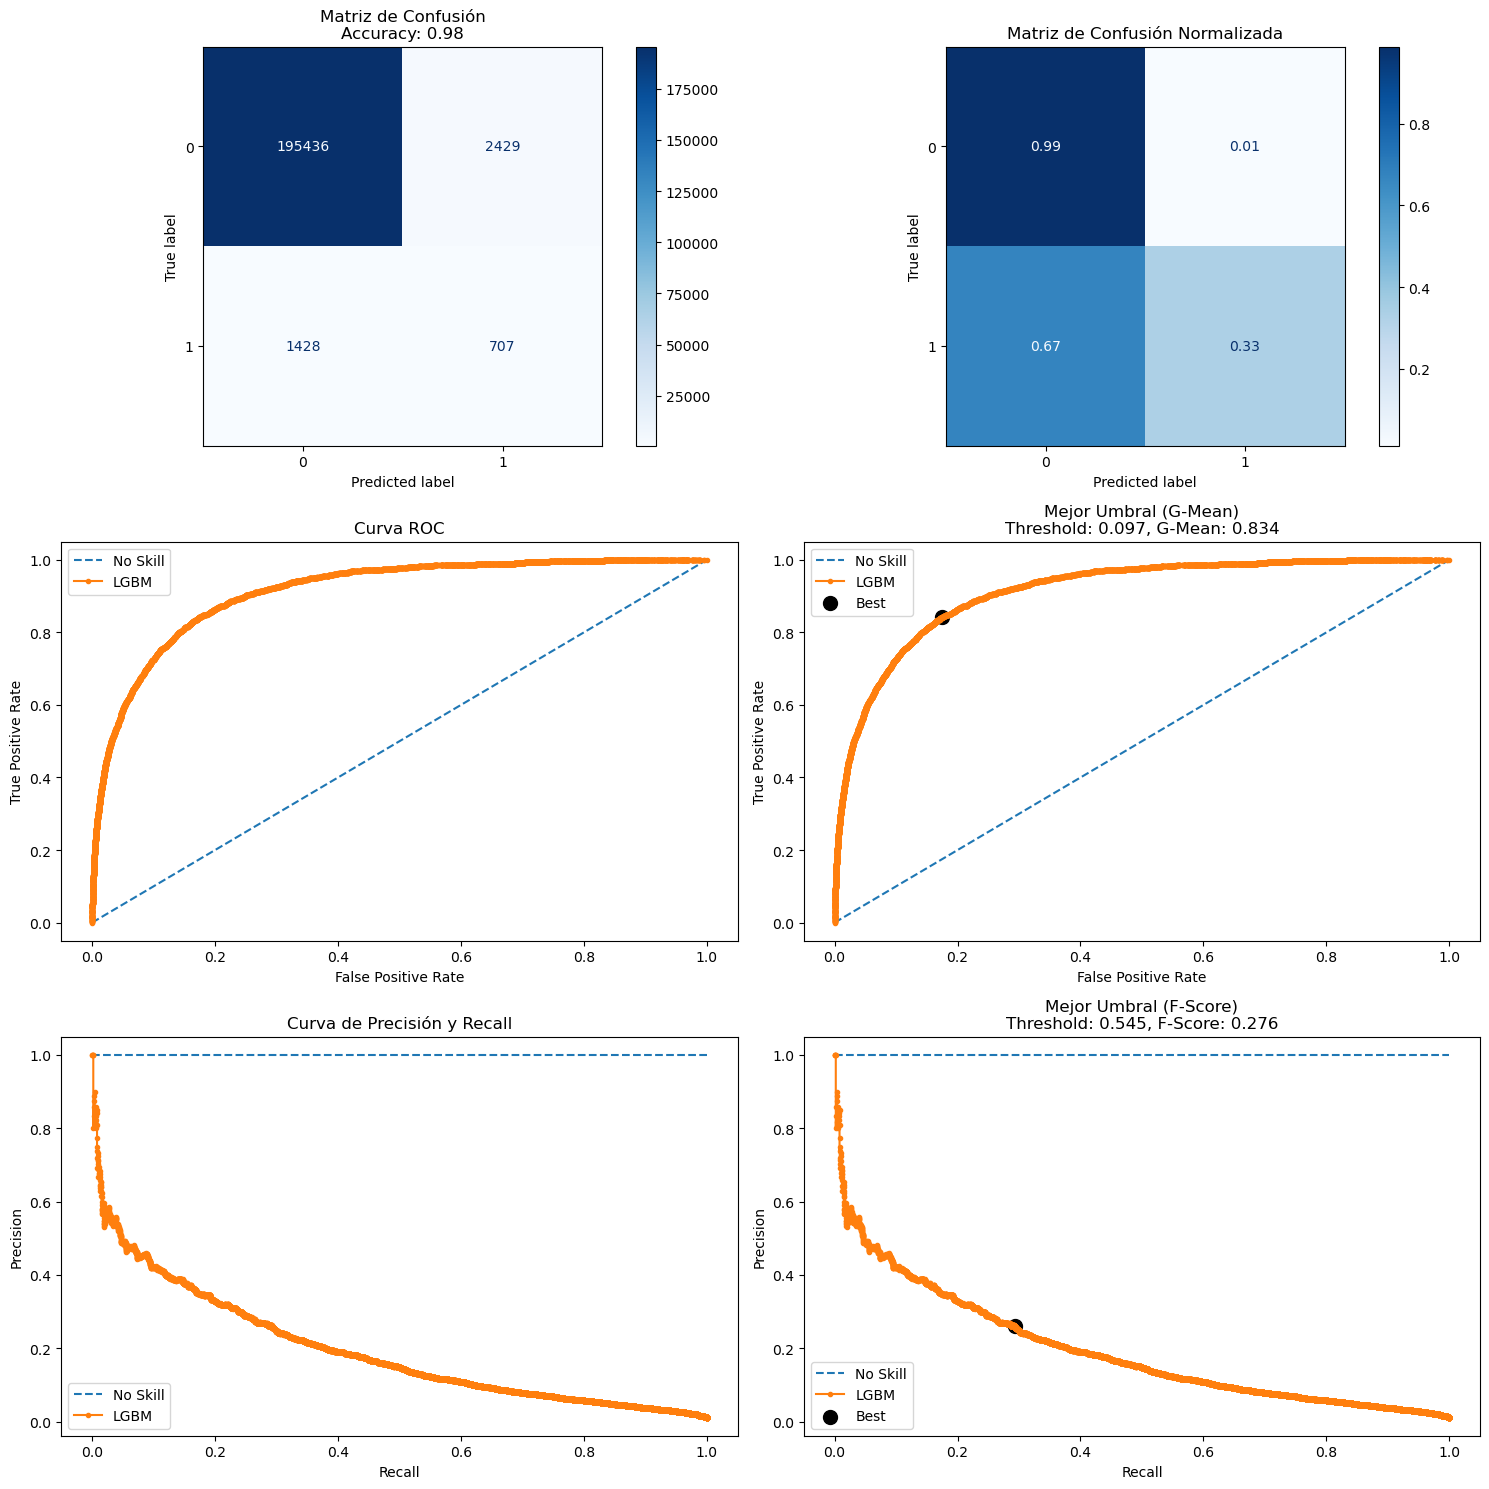

In [25]:
plot_evaluation_metrics(y_test, pred_xgb, pred_proba_xgb)

-Matriz de Confusión:  presenta una alta accuracy del 98%, indicando un buen rendimiento general del modelo. No obstante, es crucial analizar los detalles de la matriz. Se registraron 2,429 Falsos Positivos, donde el modelo predijo incorrectamente la ausencia de fraude. Además, se observaron 1,428 Falsos Negativos, representando casos en los que el modelo no logró predecir fraudes reales. Esta información revela que, a pesar de la alta precisión general, hay áreas específicas de mejora en la capacidad de detección de fraudes.

-Matriz de Confusión Normalizada: proporciona una visión más equilibrada de las tasas de error para cada clase. En particular, muestra que el modelo tiene un buen rendimiento para predecir la clase 0 (no fraude), pero tiene más dificultades para predecir correctamente la clase 1 (fraude). Este énfasis en los errores específicos ayuda a comprender mejor las áreas de mejora del modelo.

-Curva ROC: la curva ROC muestra la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos (1 - especificidad) para diferentes umbrales de clasificación. El modelo presenta un punto de operación equilibrado, con una tasa de verdaderos positivos del 80% y una tasa de falsos positivos del 20%. Esto indica que el modelo tiene una buena capacidad para distinguir entre las clases positiva y negativa.

-Mejor Umbral (G-Mean): el umbral óptimo es 0.097, con un G-Mean asociado de 0.834. Este umbral proporciona un equilibrio eficiente entre la sensibilidad y la especificidad del modelo, maximizando la capacidad para identificar transacciones fraudulentas y minimizando los falsos positivos. La optimización del G-Mean refuerza la robustez del modelo en la gestión de ambas clases.

-Curva de Precisión y Recall: indica que el modelo tiene un buen rendimiento para identificar instancias positivas. A medida que aumenta el umbral para clasificar algo como positivo, la precisión mejora a expensas de un menor recall. Encontrar el equilibrio óptimo es crucial para adaptar el modelo a los objetivos específicos.

-Mejor Umbral (F-Score): el punto “best” en esta curva representa un compromiso entre precisión y recall. El umbral de 0.545 es la configuración que maximiza el F-Score, indicando un rendimiento equilibrado del modelo en términos de clasificación positiva y captura de casos positivos. Esta métrica ofrece una perspectiva integral del rendimiento del modelo en la detección de fraudes.